In [1]:
from gc import collect

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm

In [2]:
# evaluator
from typing import Union
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation
        for gcol in ["all_id", "state_id", "store_id", "cat_id", "dept_id", "item_id"]:
            train_df.loc[:, gcol] = train_df.loc[:, gcol].astype("category")

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            setattr(self, f'lv{i + 1}_train_df', train_df.groupby(group_id)[train_target_columns].sum())
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        train_y = getattr(self, f'lv{lv}_train_df')
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = ((train_y.iloc[:, 1:].values - train_y.iloc[:, :-1].values) ** 2).mean(axis=1)
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

In [3]:
raw_train_df = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv")
prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv")
test_train_fold_df = raw_train_df.iloc[:, :-28]
test_valid_fold_df = raw_train_df.iloc[:, -28:]

In [4]:
from sklearn.metrics import mean_squared_error
class WRMSSEForLightGBM(WRMSSEEvaluator):

    def feval(self, preds, dtrain):
        preds = preds.reshape(28, -1).T
        score = self.score(preds)
        return 'WRMSSE', score, False
    
    def set_ix(self, ix):
        self.pred_ix = ix
    
    def feval2(self, preds, dtrain):
        new_preds = np.zeros(28*30490)
        new_preds[self.pred_ix] = preds
        return self.feval(new_preds, dtrain)
        
test_evaluator = WRMSSEForLightGBM(test_train_fold_df, test_valid_fold_df, calendar, prices)

C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [5]:
def load_datasets(feats):
    dfs = [pd.read_pickle(f'../processed/{f}_data.ftr') for f in feats]
    return pd.concat(dfs, axis=1)

test_rmse = []
test_wrmsse = []

param = {'num_leaves': 512,
         'min_data_in_leaf': 50, 
         'objective':'rmse',
         "metric": "None",
         "first_metric_only": True,
         'max_depth': -1,
         'learning_rate': .1,
         "boosting": "gbdt",
         "feature_fraction": 0.75,
         "bagging_freq": 10,
         "bagging_fraction": 0.75 ,
         "bagging_seed": 2434,
         "nthread":6,
         "device": "cpu",
         "verbosity": -1}

feature_importance_df = pd.DataFrame()
for epoch in range(14):
    data_df = pd.read_pickle("../processed/base_data.pickle")
    feats = ["Base", "Calendar", "Price", "Rolling_id_LAG_28", "Rolling_cor"]
    data_df = pd.concat([data_df, load_datasets(feats)], axis=1)
    
    test_data_df = data_df.query("{} <= d and d < {}".format(1914-28*(1), 1914))
    val_data_df = data_df.query("{} <= d and d < {}".format(1914-28*(epoch+1), 1914-28*(epoch)))
    
    dropcol = ["target", "d", "id", "wm_yr_wk", "next_change", "rchange_rate"]
    dev_data = lgb.Dataset(data_df.query("d < {}".format(1914-28*(epoch+1))).drop(dropcol, axis=1), label=data_df.query("d < {}".format(1914-28*(epoch+1)))["target"])
    val_data = lgb.Dataset(val_data_df.drop(dropcol, axis=1), label=val_data_df["target"])
    
    del data_df
    collect()

    ids = list(range(30490)) * 28
    ds = []
    for d in range(1914-28*(epoch+1), 1914-28*(epoch)):
        ds += [d]*30490
    origin_df = pd.DataFrame({"id": ids, "d": ds})
    origin_df = origin_df.merge(val_data_df[["id", "d", "target"]],
                                how="left",
                                on=["id", "d"])
    ix = np.where(~origin_df["target"].isna())[0]

    train_fold_df = raw_train_df.iloc[:, :-28*(epoch+1)]
    if epoch != 0:
        valid_fold_df = raw_train_df.iloc[:, -28*(epoch+1):-28*epoch]
    else:
        valid_fold_df = raw_train_df.iloc[:, -28*(epoch+1):]

    evaluator = WRMSSEForLightGBM(train_fold_df, valid_fold_df, calendar, prices)
    evaluator.set_ix(ix)
    
    num_round = 10000
    clf = lgb.train(param, dev_data, num_round, valid_sets = val_data, verbose_eval=100, early_stopping_rounds = 100, feval=evaluator.feval2)
    clf.save_model("../models/epoch_{}".format(epoch))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = test_data_df.drop(dropcol, axis=1).columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] =  epoch
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df])
    
    test_pred = clf.predict(test_data_df.drop(dropcol, axis=1),num_iteration=clf.best_iteration)
    
    test_rmse.append(np.sqrt(mean_squared_error(test_pred, test_data_df["target"])))
    test_wrmsse.append(test_evaluator.score(test_pred.reshape(28, -1).T))
    print(test_rmse[-1], test_wrmsse[-1])

C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.600262
[200]	valid_0's WRMSSE: 0.59242
[300]	valid_0's WRMSSE: 0.579306
[400]	valid_0's WRMSSE: 0.57149
[500]	valid_0's WRMSSE: 0.569519
[600]	valid_0's WRMSSE: 0.569603
Early stopping, best iteration is:
[531]	valid_0's WRMSSE: 0.568558
2.1004120160363153 0.5685771365899563


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.690333
[200]	valid_0's WRMSSE: 0.671349
[300]	valid_0's WRMSSE: 0.663095
[400]	valid_0's WRMSSE: 0.655645
[500]	valid_0's WRMSSE: 0.652527
[600]	valid_0's WRMSSE: 0.654489
Early stopping, best iteration is:
[554]	valid_0's WRMSSE: 0.651733
2.140862488855329 0.5834188019559651


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.746837
[200]	valid_0's WRMSSE: 0.725097
[300]	valid_0's WRMSSE: 0.721838
Early stopping, best iteration is:
[261]	valid_0's WRMSSE: 0.718765
2.1737945080787777 0.6402242605670682


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.681799
[200]	valid_0's WRMSSE: 0.654367
[300]	valid_0's WRMSSE: 0.638636
[400]	valid_0's WRMSSE: 0.624323
[500]	valid_0's WRMSSE: 0.6131
[600]	valid_0's WRMSSE: 0.605396
[700]	valid_0's WRMSSE: 0.602055
[800]	valid_0's WRMSSE: 0.596722
[900]	valid_0's WRMSSE: 0.596927
[1000]	valid_0's WRMSSE: 0.594502
[1100]	valid_0's WRMSSE: 0.588824
[1200]	valid_0's WRMSSE: 0.586915
[1300]	valid_0's WRMSSE: 0.586522
Early stopping, best iteration is:
[1218]	valid_0's WRMSSE: 0.586414
2.1990040489042233 0.6327965698026911


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.729666
[200]	valid_0's WRMSSE: 0.713058
[300]	valid_0's WRMSSE: 0.692983
[400]	valid_0's WRMSSE: 0.686709
[500]	valid_0's WRMSSE: 0.675937
[600]	valid_0's WRMSSE: 0.672264
[700]	valid_0's WRMSSE: 0.653764
[800]	valid_0's WRMSSE: 0.651472
[900]	valid_0's WRMSSE: 0.645438
[1000]	valid_0's WRMSSE: 0.644274
[1100]	valid_0's WRMSSE: 0.641932
[1200]	valid_0's WRMSSE: 0.642206
[1300]	valid_0's WRMSSE: 0.639367
[1400]	valid_0's WRMSSE: 0.637214
[1500]	valid_0's WRMSSE: 0.634068
[1600]	valid_0's WRMSSE: 0.63096
[1700]	valid_0's WRMSSE: 0.630521
Early stopping, best iteration is:
[1648]	valid_0's WRMSSE: 0.630372
2.1839267703527123 0.6193392274779753


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.755738
[200]	valid_0's WRMSSE: 0.720352
[300]	valid_0's WRMSSE: 0.713823
[400]	valid_0's WRMSSE: 0.703376
[500]	valid_0's WRMSSE: 0.694809
[600]	valid_0's WRMSSE: 0.687036
[700]	valid_0's WRMSSE: 0.688723
Early stopping, best iteration is:
[605]	valid_0's WRMSSE: 0.686354
2.176591934302655 0.6642430376490676


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.640564
[200]	valid_0's WRMSSE: 0.621832
[300]	valid_0's WRMSSE: 0.611464
[400]	valid_0's WRMSSE: 0.607912
[500]	valid_0's WRMSSE: 0.601467
[600]	valid_0's WRMSSE: 0.592528
[700]	valid_0's WRMSSE: 0.588492
[800]	valid_0's WRMSSE: 0.58728
[900]	valid_0's WRMSSE: 0.585125
[1000]	valid_0's WRMSSE: 0.585151
[1100]	valid_0's WRMSSE: 0.583163
[1200]	valid_0's WRMSSE: 0.581922
[1300]	valid_0's WRMSSE: 0.5807
[1400]	valid_0's WRMSSE: 0.57866
[1500]	valid_0's WRMSSE: 0.57683
[1600]	valid_0's WRMSSE: 0.575425
[1700]	valid_0's WRMSSE: 0.575136
[1800]	valid_0's WRMSSE: 0.57397
[1900]	valid_0's WRMSSE: 0.573287
[2000]	valid_0's WRMSSE: 0.571057
[2100]	valid_0's WRMSSE: 0.569391
Early stopping, best iteration is:
[2089]	valid_0's WRMSSE: 0.568978
2.19403731983268 0.6245057255026049


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.696046
[200]	valid_0's WRMSSE: 0.668699
[300]	valid_0's WRMSSE: 0.658977
[400]	valid_0's WRMSSE: 0.647341
[500]	valid_0's WRMSSE: 0.638875
[600]	valid_0's WRMSSE: 0.633642
[700]	valid_0's WRMSSE: 0.626379
[800]	valid_0's WRMSSE: 0.624936
Early stopping, best iteration is:
[736]	valid_0's WRMSSE: 0.623322
2.198787793743332 0.6433205904967452


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.679848
[200]	valid_0's WRMSSE: 0.64527
[300]	valid_0's WRMSSE: 0.636252
[400]	valid_0's WRMSSE: 0.625506
[500]	valid_0's WRMSSE: 0.620634
[600]	valid_0's WRMSSE: 0.615306
[700]	valid_0's WRMSSE: 0.610645
[800]	valid_0's WRMSSE: 0.60735
[900]	valid_0's WRMSSE: 0.60241
[1000]	valid_0's WRMSSE: 0.601893
Early stopping, best iteration is:
[984]	valid_0's WRMSSE: 0.601651
2.2254435800889443 0.6637410358575805


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.636988
[200]	valid_0's WRMSSE: 0.595668
[300]	valid_0's WRMSSE: 0.571963
[400]	valid_0's WRMSSE: 0.567448
[500]	valid_0's WRMSSE: 0.559415
[600]	valid_0's WRMSSE: 0.550214
[700]	valid_0's WRMSSE: 0.543281
[800]	valid_0's WRMSSE: 0.541909
[900]	valid_0's WRMSSE: 0.538987
[1000]	valid_0's WRMSSE: 0.53594
[1100]	valid_0's WRMSSE: 0.53569
[1200]	valid_0's WRMSSE: 0.533068
[1300]	valid_0's WRMSSE: 0.532808
[1400]	valid_0's WRMSSE: 0.531518
[1500]	valid_0's WRMSSE: 0.529649
[1600]	valid_0's WRMSSE: 0.527951
[1700]	valid_0's WRMSSE: 0.527559
[1800]	valid_0's WRMSSE: 0.526346
[1900]	valid_0's WRMSSE: 0.527693
Early stopping, best iteration is:
[1803]	valid_0's WRMSSE: 0.525819
2.235497247285811 0.6183187334324919


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.745751
[200]	valid_0's WRMSSE: 0.716211
[300]	valid_0's WRMSSE: 0.708319
[400]	valid_0's WRMSSE: 0.690684
[500]	valid_0's WRMSSE: 0.693286
Early stopping, best iteration is:
[472]	valid_0's WRMSSE: 0.687917
2.2049815559611505 0.671828266136378


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.762871
[200]	valid_0's WRMSSE: 0.727196
[300]	valid_0's WRMSSE: 0.713262
[400]	valid_0's WRMSSE: 0.708538
[500]	valid_0's WRMSSE: 0.707525
[600]	valid_0's WRMSSE: 0.703354
[700]	valid_0's WRMSSE: 0.70295
[800]	valid_0's WRMSSE: 0.703712
Early stopping, best iteration is:
[702]	valid_0's WRMSSE: 0.702821
2.1998380034088214 0.6842225956723134


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.626883
[200]	valid_0's WRMSSE: 0.611163
[300]	valid_0's WRMSSE: 0.601023
[400]	valid_0's WRMSSE: 0.58688
[500]	valid_0's WRMSSE: 0.579525
[600]	valid_0's WRMSSE: 0.574724
Early stopping, best iteration is:
[567]	valid_0's WRMSSE: 0.57427
2.2102840806869843 0.6913334747981134


C:\Users\nadare\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's WRMSSE: 0.644626
[200]	valid_0's WRMSSE: 0.612408
[300]	valid_0's WRMSSE: 0.60591
[400]	valid_0's WRMSSE: 0.599145
[500]	valid_0's WRMSSE: 0.59536
[600]	valid_0's WRMSSE: 0.594174
[700]	valid_0's WRMSSE: 0.594339
[800]	valid_0's WRMSSE: 0.588878
[900]	valid_0's WRMSSE: 0.587951
[1000]	valid_0's WRMSSE: 0.585105
[1100]	valid_0's WRMSSE: 0.581759
[1200]	valid_0's WRMSSE: 0.581488
[1300]	valid_0's WRMSSE: 0.581549
[1400]	valid_0's WRMSSE: 0.579544
[1500]	valid_0's WRMSSE: 0.579024
Early stopping, best iteration is:
[1410]	valid_0's WRMSSE: 0.578607
2.300565939704412 0.7227519600152511


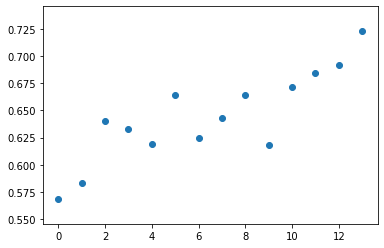

In [6]:
plt.scatter(range(14), test_wrmsse)
plt.ylanel("")
plt.savefig("lagvswrmmse.png")

In [7]:
pd.options.display.max_rows = 999
feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False)

feature
id_lag_28_rmean_7                   15108.857143
id_lag_28_rmean_1                   11938.000000
id_autocor_r7_d28_w91               11910.642857
id_item_r28_w91                     11574.714286
item_id_autocor_r7_d28_w91          11414.428571
id_lag_1y_rmean_7                   11346.214286
id_autocor_r1_d7_w91                11305.142857
item_id_dept_r28_w91                11008.214286
id_store_r28_w91                    10914.357143
id_lag_28_rskew_28                  10823.142857
id_lag_28_rkurt_28                  10517.857143
id_dept_r28_w91                     10472.357143
id_autocor_r28_d364_w91             10443.000000
id_store_dept_r28_w91               10313.071429
item_id_autocor_r1_d7_w91           10309.785714
last_changed                        10074.500000
id_lag_28_rmean_28                  10052.571429
item_id_autocor_r28_d364_w91         9857.357143
item_id_lag_28_rstd_28               9835.642857
item_id_lag_28_rkurt_28              9661.357143
item_id     